In [39]:
import re #regex
import os #operating system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [40]:
directory = 'csv/nvprof_perfomances'
files = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if (re.match("^fwb_dev_v_.*", filename)) and (not re.match("^fwb_dev_v_.*_pitch.*", filename)):
      files.append(file_path)
      print(file_path)

csv/nvprof_perfomances/fwb_dev_v_1_1__n_080__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_080__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_1200__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_1200__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_1200__b_24__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_160__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_160__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_160__b_32__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_240__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_240__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_240__b_24__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_320__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_320__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_320__b_32__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_480__b_08__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1__n_480__b_16__t_10.csv
csv/nvprof_perfomances/fwb_dev_v_1_1_

In [41]:
# for filename in files :
#     f = open(filename, "r")
#     print(f.read())
#     f.close()

In [42]:
def obtain_parameter(in_string, par_name) :
    par_regex = "-" + par_name + "=[^ \n]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub(".*=", "", par_string)
    return par_value

def obtain_version(in_string) :
    par_regex = "v_[^. ]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub("v_", "", par_string)
    return par_value

In [43]:
def obtain_all_parameters(in_file) :
    with open(in_file) as fp :
      for i, line in enumerate(fp) :
        if i == 0 :
            n = int(obtain_parameter(line, "n"))
            b = int(obtain_parameter(line, "b"))
            t = int(obtain_parameter(line, "t"))
            s = int(obtain_parameter(line, "s"))
            version = obtain_version(line)

        elif i == 3 :
            headers = line.replace('"', '').replace("\n", "").split(",")

        elif i == 4 :
            temp = line.replace("\n", "").replace("%", "").split(",")
            unit_measures = []
            for unit in temp :
              if unit != "" :
                unit = "(" + unit + ")"
              unit_measures.append(unit)

        elif i > 4 :
            break

    headers = list(map(lambda x, y: x + y, headers, unit_measures))

    return n, b, t, s, version, headers

In [44]:
def print_large(df) :
    with pd.option_context('display.max_columns', None, 'expand_frame_repr', False):
        print(df)

In [45]:
df_nvprof_big = pd.DataFrame()     # collects all data
df_nvprof = pd.DataFrame()   # sums up everything
for filename in files : 
    #print(filename)
    n, b, t, s, version, headers = obtain_all_parameters(filename)
    time = headers[2]
    temp_df_big = pd.read_csv(filename, skiprows=5, names=headers)
    temp_df_big['version'] = version
    temp_df_big['n'] = n
    temp_df_big['b'] = b
    temp_df_big['tests'] = t
    temp_df_big['seed'] = s
    if df_nvprof.empty :
      df_nvprof_big = pd.DataFrame(columns = headers)
      df_nvprof = pd.DataFrame(columns = ['version', 'n', 'b', 'tests', 'seed', time])
    df_nvprof_big = pd.concat([df_nvprof_big, temp_df_big])
    tot_time = temp_df_big[time].sum()
    #print(f"version = {version}, n = {n}, b = {b}, t = {t}, tot_time = {tot_time:.2f}")
    df_nvprof.loc[-1] = [version, n, b, t, s, tot_time]  # adding a row
    df_nvprof.index = df_nvprof.index + 1  # shifting index
    df_nvprof = df_nvprof.sort_index()  # sorting by index
df_nvprof = df_nvprof.sort_values(by = ['n', 'b', 'seed', 'tests', time])


In [46]:
#GPU, API in detail
print_large(df_nvprof_big)

              Type    Time(%)   Time(ms)  Calls   Avg(ms)   Min(ms)   Max(ms)                                               Name version      n     b  tests       seed
0   GPU activities  99.856998  50.120426  10000  0.005012   0.00384  0.013217  execute_round_device_v_1_1(int*, int, int, int...     1_1   80.0   8.0   10.0  8543799.0
1   GPU activities   0.084858   0.042592     10  0.004259  0.004192  0.004544                                 [CUDA memcpy HtoD]     1_1   80.0   8.0   10.0  8543799.0
2   GPU activities   0.058144   0.029184     10  0.002918  0.002848  0.003168                                 [CUDA memcpy DtoH]     1_1   80.0   8.0   10.0  8543799.0
3        API calls  67.155106  50.012157  10000  0.005001  0.003363  1.410444                                   cudaLaunchKernel     1_1   80.0   8.0   10.0  8543799.0
4        API calls  17.048004  12.696093    300   0.04232  0.003372  0.142958                              cudaDeviceSynchronize     1_1   80.0   8.0   10.0  85

In [47]:
#total sum per each (version,n,b,seed)
done = False
if not done :
    df_nvprof[time] = df_nvprof[time] / df_nvprof['tests']
    done = True
print(df_nvprof)


    version     n   b  tests     seed     Time(ms)
143     1_4    80   8     10  8543799     1.944642
167     1_3    80   8     10  8543799     1.951211
119     2_0    80   8     10  8543799     1.956054
95      2_2    80   8     10  8543799     1.973130
191     1_2    80   8     10  8543799     1.988931
..      ...   ...  ..    ...      ...          ...
139     1_4  1200  24     10  8543799    79.802977
43      3_1  1200  24     10  8543799    84.353618
187     1_2  1200  24     10  8543799   188.394056
19      3_2  1200  24     10  8543799   210.727276
211     1_1  1200  24     10  8543799  6632.728863

[216 rows x 6 columns]


In [48]:
df_chrono = pd.read_csv('csv/chrono_performances.csv')
done = False
if not done :
    df_chrono['Mean Squared Error(%)'] = df_chrono['Mean Squared Error(%)'].str.strip('%').astype(float) / 100
    done = True
print(df_chrono)

    version     seed     n   b   t   Time(ms)  Mean Squared Error(ms)  \
0       1_3  5929024    80   8  10   1.650665                4.207820   
1       1_3  5929024    80  16  10   1.245507                2.684326   
2       1_3  5929024   160   8  10   2.106198                2.607151   
3       1_3  5929024   160  16  10   2.059278                2.561897   
4       1_3  5929024   160  32  10   2.464175                2.549266   
..      ...      ...   ...  ..  ..        ...                     ...   
211     2_2  5929024   720  16  10  16.697358                4.533891   
212     2_2  5929024   720  24  10  16.197677                2.600660   
213     2_2  5929024  1200   8  10  49.885303                3.076880   
214     2_2  5929024  1200  16  10  48.429155                5.716060   
215     2_2  5929024  1200  24  10  46.406707                5.357946   

     Mean Squared Error(%)  
0                 2.549166  
1                 2.155208  
2                 1.237847  
3      

In [49]:
na_columns = df_nvprof_big.columns[df_nvprof_big.isna().any()].tolist()
if na_columns == [] :
    print("No NaN values found")
else :
    print("Columns with NaN:")
    print(na_columns)

No NaN values found


In [56]:
versions_to_remove = [ '1_1' ] #, '1_2', '1_3', '1_4', '3_1', '3_2']
versions = np.unique(df_nvprof['version'])
versions = versions.tolist()
versions = [ elem for elem in versions if elem not in versions_to_remove]
print(versions)

['1_2', '1_3', '1_4', '2_0', '2_2', '3_0', '3_1', '3_2']


In [73]:
def plot_perf_version(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 2
    fig, axis = plt.subplots(rows, cols, figsize=(15, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    title = y_axis + " performance of versions with " + analyzer
    fig.suptitle(title,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for b in range(8, 33, 8):
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['b'] == b)]
        for label, grp in df_plot.groupby(['version']):
            sub_title = "B = " + str(b)
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/' + title + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

In [74]:
def plot_perf_B(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 4
    fig, axis = plt.subplots(rows, cols, figsize=(25, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    title = y_axis + " performance of blocking factors with " + analyzer
    fig.suptitle(title,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for v in versions:
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['version'] == v)]
        for label, grp in df_plot.groupby(['b']):
            sub_title = "version = " + v
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/' + title + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

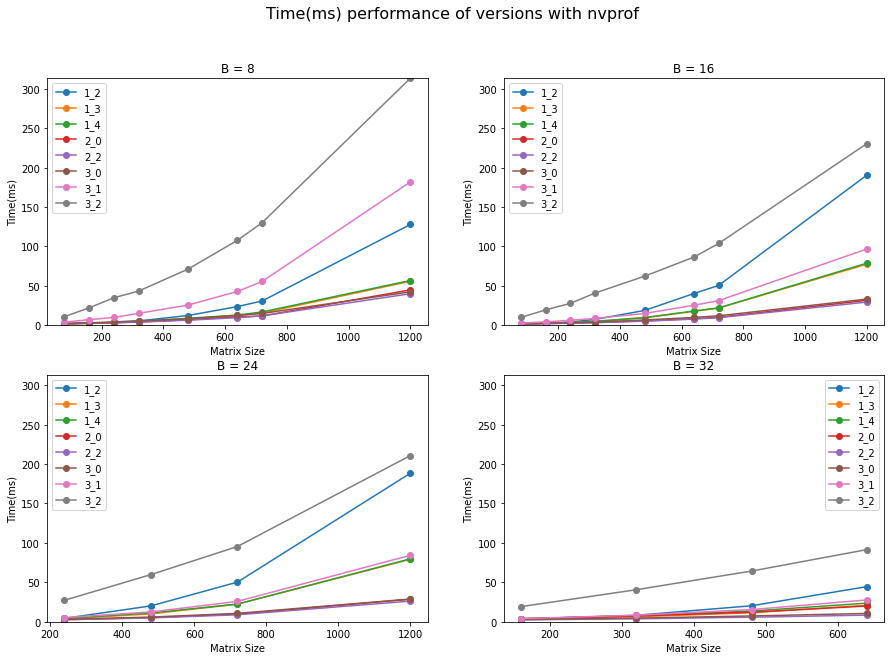

In [75]:
plot_perf_version(df_nvprof, time, 'nvprof')

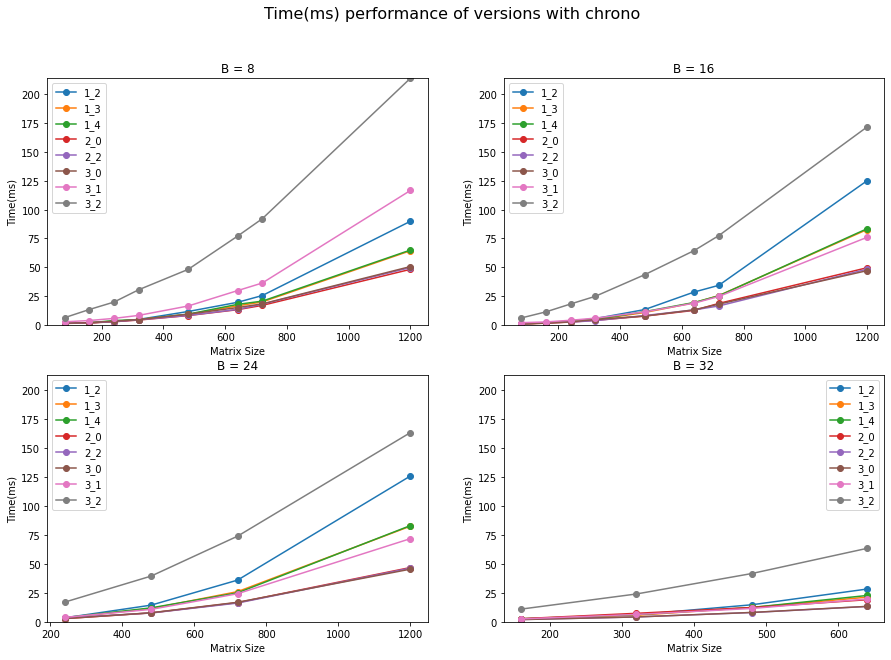

In [76]:
plot_perf_version(df_chrono, 'Time(ms)', 'chrono')

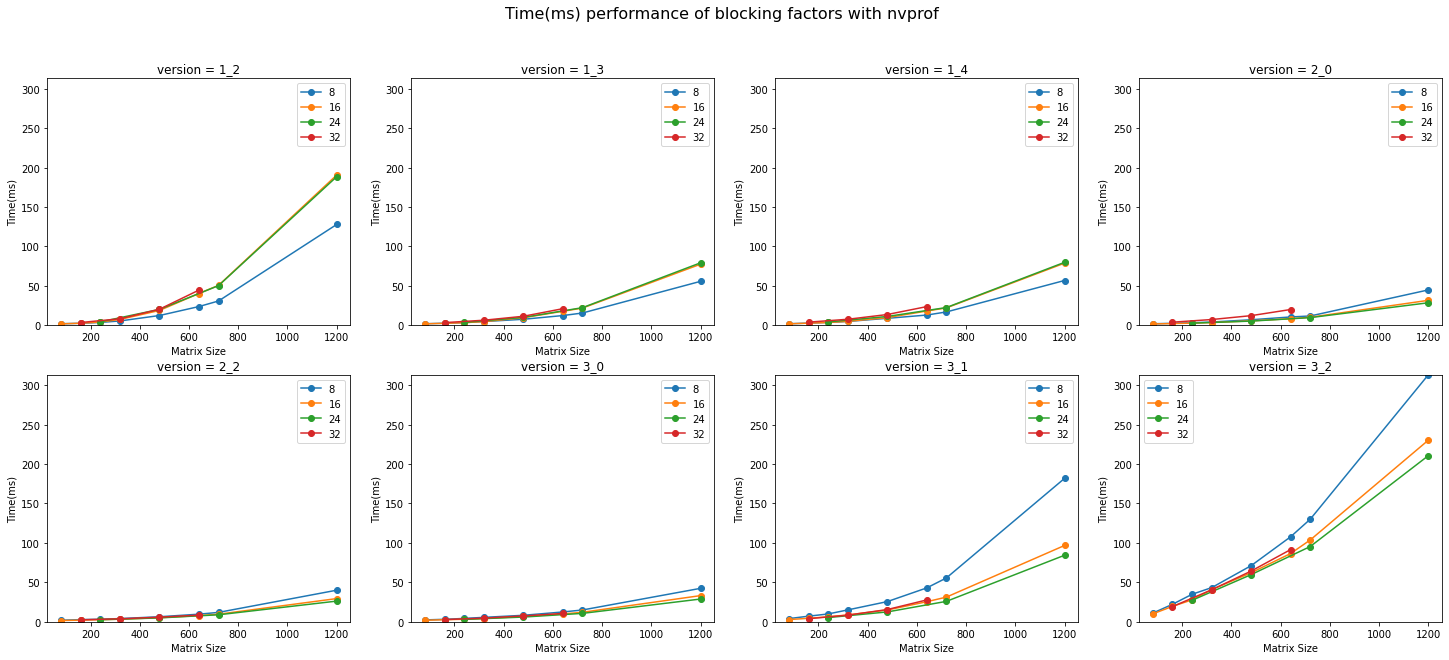

In [77]:
plot_perf_B(df_nvprof, time, 'nvprof')

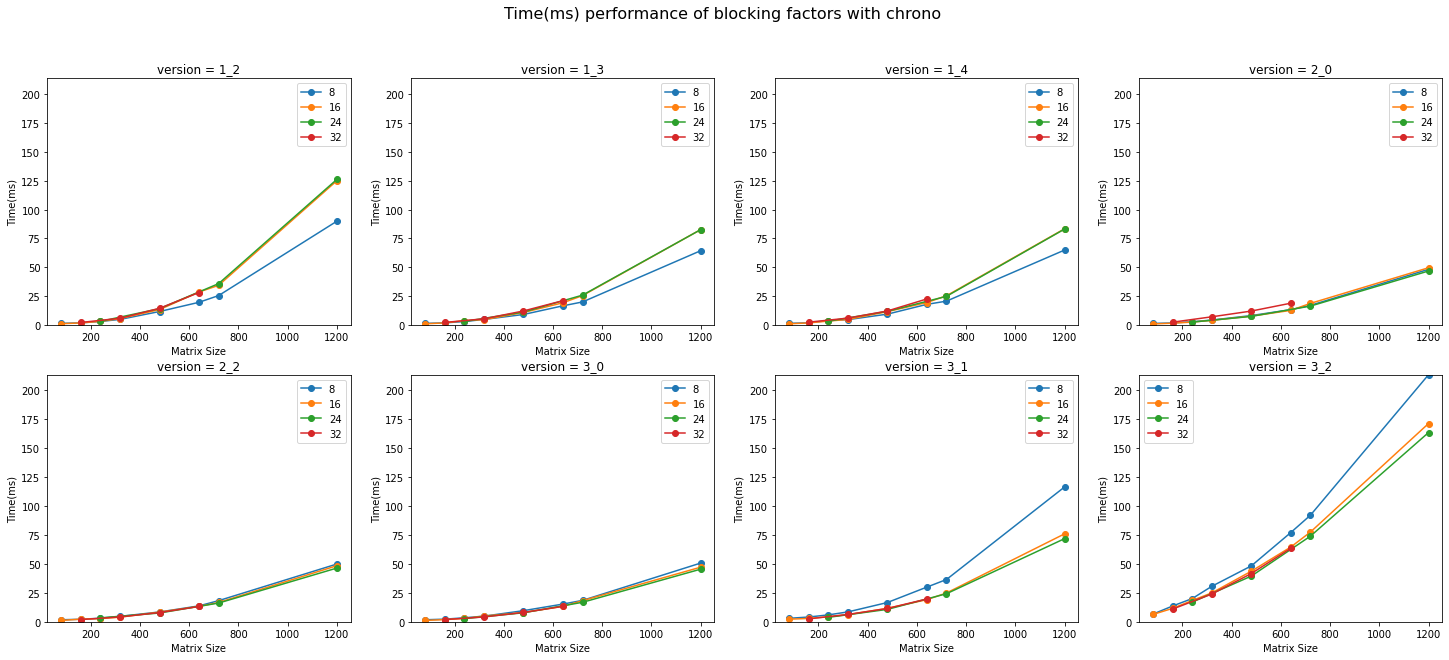

In [78]:
plot_perf_B(df_chrono, 'Time(ms)', 'chrono')

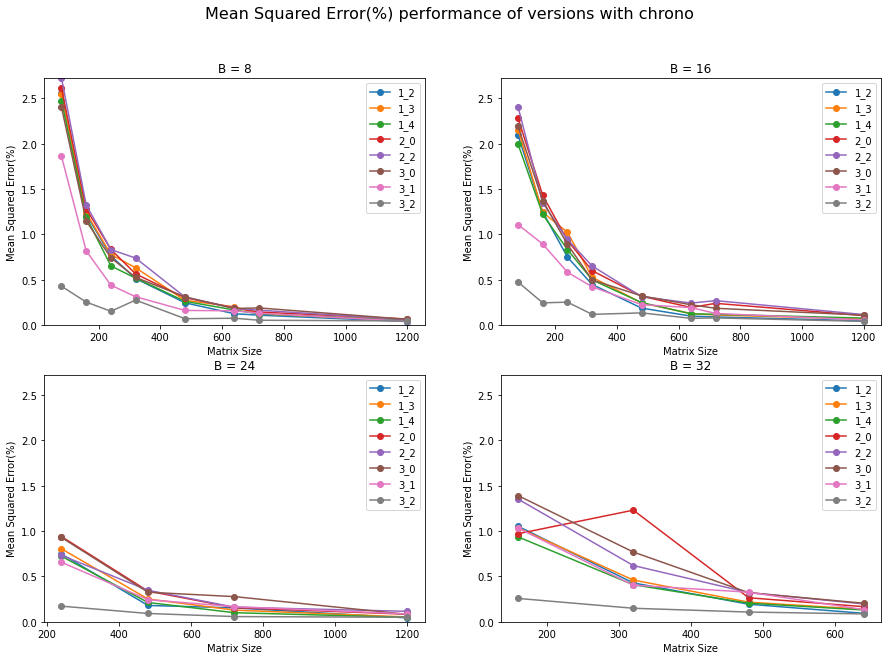

In [79]:
plot_perf_version(df_chrono, 'Mean Squared Error(%)', 'chrono')

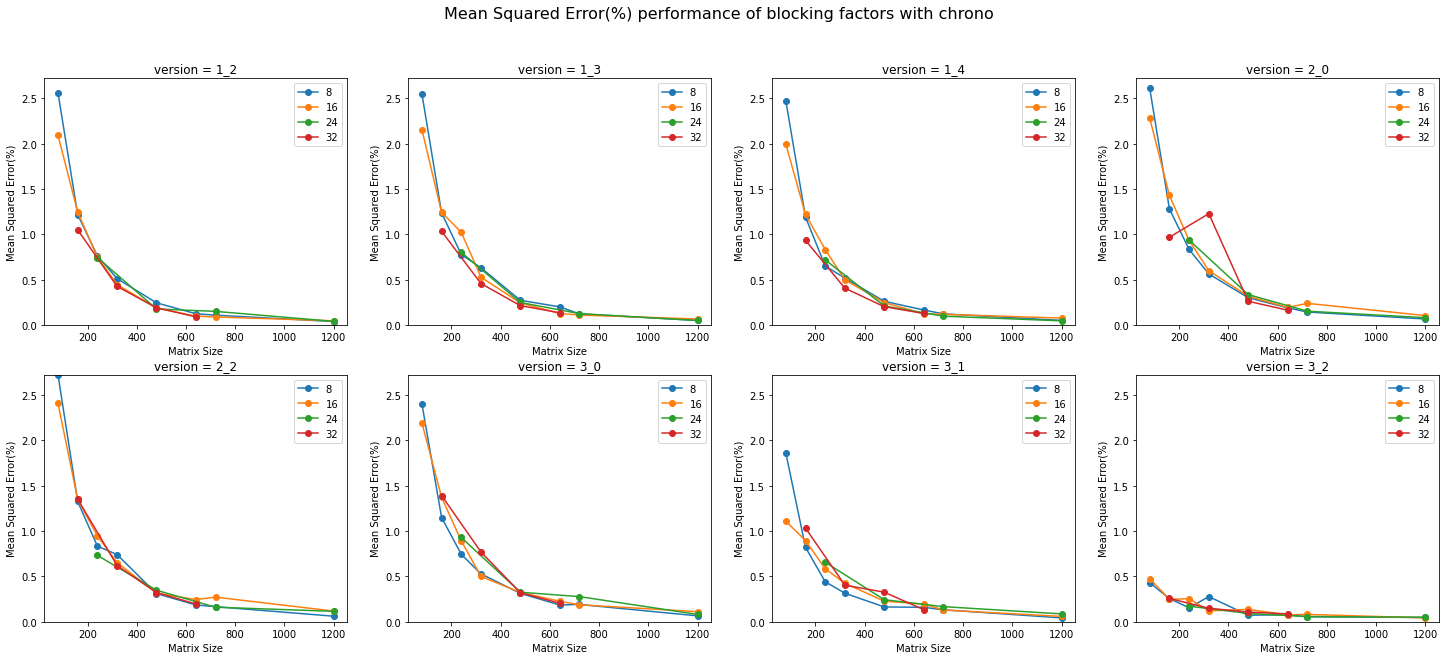

In [80]:
plot_perf_B(df_chrono, 'Mean Squared Error(%)', 'chrono')